<a href="https://colab.research.google.com/github/satyam-311/ATS-score-checker/blob/main/demographic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Analysis: Simulating a One-Child Policy in India

This notebook provides a step-by-step implementation of a data science project to analyze the hypothetical impact of a one-child policy on resource distribution in India. We will:
1.  Fetch real-world demographic data from international sources.
2.  Perform exploratory data analysis (EDA) to understand historical trends.
3.  Build a simplified population simulation model.
4.  Run two scenarios: a baseline and a one-child policy scenario.
5.  Analyze and visualize the results.

## Step 1: Setup and Libraries
First, we install and import the necessary Python libraries for data handling, API requests, and visualization.

In [2]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn requests scikit-learn -q

# Import libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


## Step 2: Data Acquisition via API (World Bank Data)
We will fetch historical data for India and China from the World Bank. This provides a reliable baseline for key indicators like population and fertility rate.

In [3]:
# Define the World Bank API endpoint and the indicators we want
BASE_URL = "http://api.worldbank.org/v2/country/"
INDICATORS = {
    "Total_Population": "SP.POP.TOTL",
    "Fertility_Rate": "SP.DYN.TFRT.IN"
}
COUNTRIES = "IN;CN"  # IN for India, CN for China
DATE_RANGE = "1980:2023" # A relevant date range

all_data = []

# Loop through each indicator to fetch data
for key, indicator_code in INDICATORS.items():
    url = f"{BASE_URL}{COUNTRIES}/indicator/{indicator_code}?date={DATE_RANGE}&format=json&per_page=1000"

    print(f"Fetching data for: {key}...")
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()[1]  # The actual data is in the second element
        if data: # Check if data is not None
            for entry in data:
                all_data.append({
                    "Country": entry['country']['value'],
                    "Year": int(entry['date']),
                    "Indicator": key,
                    "Value": entry['value']
                })
    else:
        print(f"Failed to fetch data for {key}. Status code: {response.status_code}")

# Convert the list of dictionaries to a pandas DataFrame
df_world_bank = pd.DataFrame(all_data)
df_world_bank.dropna(inplace=True) # Drop rows with missing values

# Pivot the table for easier analysis
df_pivot = df_world_bank.pivot_table(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()

print("\nSample of Fetched & Pivoted Data:")
print(df_pivot.head())

Fetching data for: Total_Population...
Fetching data for: Fertility_Rate...

Sample of Fetched & Pivoted Data:
Indicator Country  Year  Fertility_Rate  Total_Population
0           China  1980           2.739      9.812350e+08
1           China  1981           2.792      9.938850e+08
2           China  1982           2.972      1.008630e+09
3           China  1983           2.559      1.023310e+09
4           China  1984           2.607      1.036825e+09


## Step 3: Data Acquisition via Manual Download (Indian Government Data)

For more granular data (e.g., state-wise), you often need to download files directly from government portals.

**Action Required:**
1. Go to a portal like [data.gov.in](https://data.gov.in/) or the [National Family Health Survey (NFHS)](http://rchiips.org/nfhs/) website.
2. Download a relevant dataset (e.g., state-wise resource data) as a CSV file.
3. In Colab, click the **folder icon** on the left sidebar, then click the **"Upload to session storage"** button (file icon with an up arrow) and select the CSV you downloaded.
4. **Update the filename** in the code cell below to match the file you uploaded.

In [5]:
# Update 'your_file_name.csv' to the name of the file you uploaded
file_name = 'your_file_name.csv'

try:
    df_indian_states = pd.read_csv(file_name)
    print("Successfully loaded your custom dataset.")
    print(df_indian_states.head())
except FileNotFoundError:
    print(f"File '{file_name}' not found.")
    print("Please upload a file and update the 'file_name' variable in this cell.")

File 'your_file_name.csv' not found.
Please upload a file and update the 'file_name' variable in this cell.


## Step 4: Exploratory Data Analysis (EDA)
Let's visualize the historical fertility rates of India and China to understand the context. China's one-child policy was implemented around 1980, and its effect is clearly visible in the data.

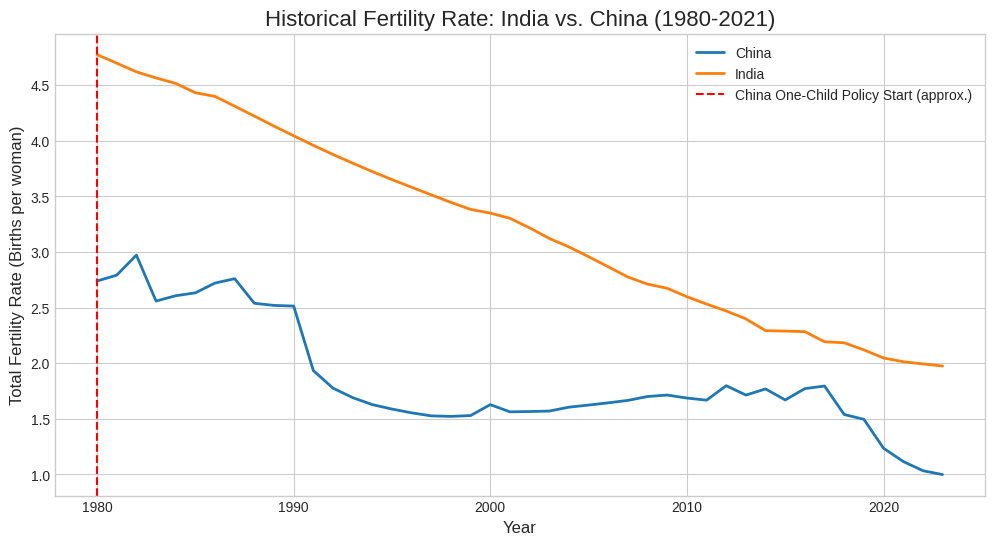

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_pivot, x='Year', y='Fertility_Rate', hue='Country', lw=2)

plt.title('Historical Fertility Rate: India vs. China (1980-2021)', fontsize=16)
plt.ylabel('Total Fertility Rate (Births per woman)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.axvline(x=1980, color='red', linestyle='--', label='China One-Child Policy Start (approx.)')
plt.legend()
plt.show()

## Step 5: Building the Simulation Model
This is the core of our project. We will create a simplified function to project population growth.

**Note:** A professional demographic model (like a cohort-component model) would be far more complex, breaking down the population by age and gender cohorts and applying different mortality/fertility rates to each. This is a high-level simplification for demonstration.

In [7]:
def project_population(initial_population, initial_fertility_rate, years_to_project, policy_effect, mortality_rate=0.007):
    """
    A simplified function to project population growth.
    - policy_effect: The target fertility rate under the new policy.
    - mortality_rate: A simplified death rate.
    """
    population_projection = [initial_population]
    current_fertility = initial_fertility_rate

    for year in range(1, years_to_project + 1):
        # Assume the policy takes 5 years to be fully effective
        if year <= 5:
            # Linearly decrease fertility rate to the policy target
            current_fertility -= (initial_fertility_rate - policy_effect) / 5
        else:
            current_fertility = policy_effect

        # Simplified growth calculation:
        # Assuming half the population is female, and they give birth according to the fertility rate over their lifetime (~30 years)
        births = (population_projection[-1] / 2) * (current_fertility / 30)
        deaths = population_projection[-1] * mortality_rate

        next_year_pop = population_projection[-1] + births - deaths
        population_projection.append(next_year_pop)

    return population_projection

def calculate_resource_demand(population_projection, resource_per_capita):
    """Calculates total resource demand based on population."""
    return np.array(population_projection) * resource_per_capita

## Step 6: Running the Simulation & Analyzing Results
Now we'll run our model with two different scenarios for India:
1.  **Baseline Scenario:** Assumes the fertility rate continues its slow, natural decline.
2.  **One-Child Policy Scenario:** Assumes a policy is enacted that forces the fertility rate down to 1.0.

Starting simulation from year 2023 with:
  - Initial Population: 1,438,069,596
  - Initial Fertility Rate: 1.98


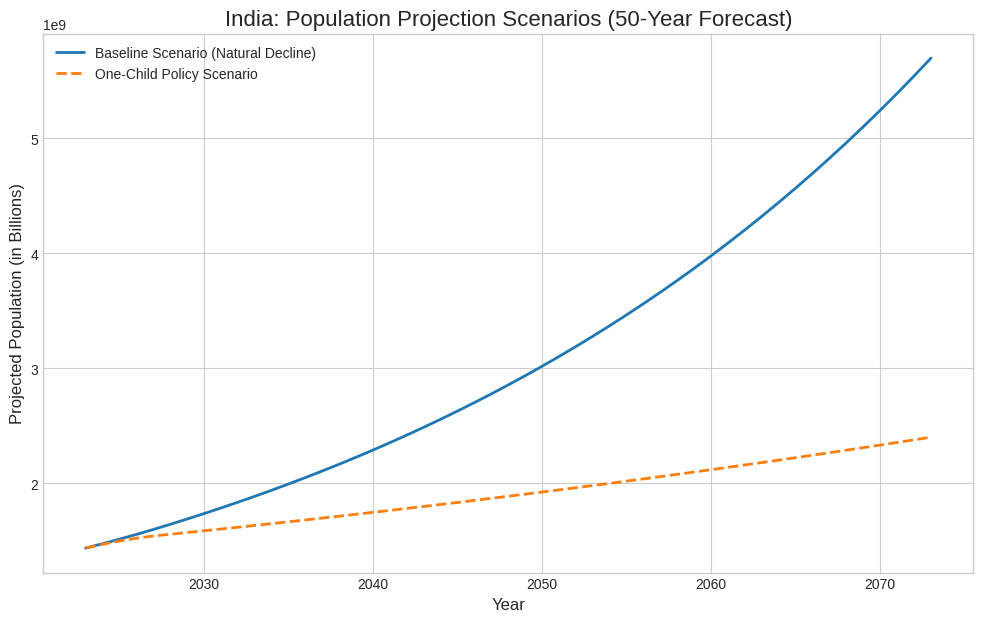

In [8]:
# Get India's latest available data from our dataframe
india_latest = df_pivot[df_pivot['Country'] == 'India'].sort_values('Year').iloc[-1]
initial_pop_india = india_latest['Total_Population']
initial_fertility_india = india_latest['Fertility_Rate']
latest_year = int(india_latest['Year'])

print(f"Starting simulation from year {latest_year} with:")
print(f"  - Initial Population: {initial_pop_india:,.0f}")
print(f"  - Initial Fertility Rate: {initial_fertility_india:.2f}")

# --- Run Scenarios ---
projection_years = 50

# Scenario 1: Baseline (assumes fertility slowly drifts to a replacement rate of 2.1)
baseline_projection = project_population(initial_pop_india, initial_fertility_india, projection_years, policy_effect=2.1)

# Scenario 2: One-Child Policy (fertility forced to 1.0)
policy_projection = project_population(initial_pop_india, initial_fertility_india, projection_years, policy_effect=1.0)

# --- Create a DataFrame for Analysis ---
years = range(latest_year, latest_year + projection_years + 1)
df_projection = pd.DataFrame({
    'Year': years,
    'Baseline_Population': baseline_projection,
    'One_Child_Policy_Population': policy_projection
})

# --- Visualize the Population Projections ---
plt.figure(figsize=(12, 7))
plt.plot(df_projection['Year'], df_projection['Baseline_Population'], label='Baseline Scenario (Natural Decline)', lw=2)
plt.plot(df_projection['Year'], df_projection['One_Child_Policy_Population'], label='One-Child Policy Scenario', linestyle='--', lw=2)

plt.title('India: Population Projection Scenarios (50-Year Forecast)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Projected Population (in Billions)', fontsize=12)
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(9,9)) # Format y-axis to billions
plt.grid(True)
plt.show()

### Analysis of Resource Demand
Let's apply our `calculate_resource_demand` function to a hypothetical resource, like annual water requirement.

In [9]:
# Example: Annual water requirement per capita in cubic meters
# (This is a simplified assumption for demonstration)
water_per_capita_m3 = 1100

df_projection['Baseline_Water_Demand_m3'] = calculate_resource_demand(df_projection['Baseline_Population'], water_per_capita_m3)
df_projection['Policy_Water_Demand_m3'] = calculate_resource_demand(df_projection['One_Child_Policy_Population'], water_per_capita_m3)

# Show the results for key years
print("Projected Annual Water Demand (in Trillion cubic meters)")
display_years = [latest_year, latest_year + 10, latest_year + 25, latest_year + 50]
results = df_projection[df_projection['Year'].isin(display_years)].copy()

# Format for readability
results['Baseline_Water_Demand_m3'] = results['Baseline_Water_Demand_m3'] / 1e12
results['Policy_Water_Demand_m3'] = results['Policy_Water_Demand_m3'] / 1e12

results.rename(columns={
    'Baseline_Water_Demand_m3': 'Baseline Demand (Trillion m³)',
    'Policy_Water_Demand_m3': 'Policy Demand (Trillion m³)'
}, inplace=True)

print(results[['Year', 'Baseline Demand (Trillion m³)', 'Policy Demand (Trillion m³)']].round(2))

Projected Annual Water Demand (in Trillion cubic meters)
    Year  Baseline Demand (Trillion m³)  Policy Demand (Trillion m³)
0   2023                           1.58                         1.58
10  2033                           2.08                         1.80
25  2048                           3.14                         2.08
50  2073                           6.27                         2.64
